# vLSTM forecasting of renewable energy grid production
## - Take mean of every 10 timesteps
## - 32,500 timesteps = 325,000 minutes = ~225.7 days: 60% training, 20% validation, 20% test
## - Lookback = 12 timesteps = 2hr
## - lr = 0.001, hidden_size = 35, num_epochs = 50, batch_size = 512

## Model Architecture
### 1 vLinear input layer
### 1 vLSTM
### 2 vLinear layers, 2nd to output

### Import packages, set seed, define model

In [1]:
from LSTMv import LSTMReparameterization
from data_handler import *
from trainer import *
from uncertainty import *
from linear_variational import *

import torch
import torch.nn as nn
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import random

def set_random_seed(seed_value=42):
    # Python random seed
    random.seed(seed_value)
    
    # Numpy random seed
    np.random.seed(seed_value)
    
    # PyTorch seed
    torch.manual_seed(seed_value)
    
    # If using CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True  # For reproducibility
        torch.backends.cudnn.benchmark = False  # Disable auto-optimization for determinism

set_random_seed()

class LSTMReparameterizationModel(nn.Module):
    def __init__(self, in_features, hidden_size, out_features, num_layers, prior_mean=0, prior_variance=0.5, posterior_rho_init=-4.0, bias=True):
        super(LSTMReparameterizationModel, self).__init__()

        # Initial linear layer
        self.fc1 = LinearReparameterization(
            in_features=in_features,
            out_features=hidden_size,
            prior_mean=prior_mean,
            prior_variance=prior_variance,
            posterior_rho_init=posterior_rho_init,
            bias=bias
        )

        # Define multiple LSTM layers
        self.lstm_layers = nn.ModuleList([
            LSTMReparameterization(
                in_features=hidden_size if i == 0 else hidden_size,
                out_features=hidden_size,
                prior_mean=prior_mean,
                prior_variance=prior_variance,
                bias=bias
            ) for i in range(num_layers)
        ])

        # Additional linear layers
        self.fc2 = LinearReparameterization(
            in_features=hidden_size,
            out_features=hidden_size,
            prior_mean=prior_mean,
            prior_variance=prior_variance,
            posterior_rho_init=posterior_rho_init,
            bias=bias
        )

        self.fc3 = LinearReparameterization(
            in_features=hidden_size,
            out_features=out_features,
            prior_mean=prior_mean,
            prior_variance=prior_variance,
            posterior_rho_init=posterior_rho_init,
            bias=bias
        )
        

    def forward(self, x, hidden_states=None):
        # Pass input through the first linear layer
        x, kl1 = self.fc1(x)
        x = F.relu(x)  # Apply ReLU activation

        # Track total KL divergence
        kl_total = kl1

        # Initialize the hidden sequence
        hidden_seq = x
    
        # Pass through LSTM layers
        for lstm in self.lstm_layers:
            hidden_seq, (hidden_last, _), kl_lstm = lstm(hidden_seq, hidden_states)
            kl_total += kl_lstm
    
        # Get the output for the **last time step** only: [batch_size, hidden_size]
        hidden_last_step = hidden_seq[:, -1, :]  # Last time step
        
        # Pass through the second linear layer
        hidden_last_step, kl2 = self.fc2(hidden_last_step)
        hidden_last_step = F.relu(hidden_last_step)  # Apply ReLU activation

        # Pass through the final linear layer
        output, kl3 = self.fc3(hidden_last_step)

        # Sum up all KL divergences
        kl_total += kl2 + kl3

        # Return output and total KL divergence
        return output, kl_total

### Loading, downsampling, scaling, and preparing of data

In [2]:
#-----------------------------------------------LOAD DATA---------------------------------------------------------#
df = pd.read_csv('../dataset/PSML.csv')
print(df.shape)

# Convert the 'time' column to datetime and set it as the index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df_mean10 = df.resample('10min').mean()

# Reset the index and drop the old index column
df_mean10 = df_mean10.reset_index(drop=True)

columns = df_mean10.columns
print(columns)
print(df_mean10.shape)

data = df_mean10.iloc[:32500]
print(data.shape)
data.head()

(1573923, 12)
Index(['load_power', 'wind_power', 'solar_power', 'DHI', 'DNI', 'GHI',
       'Dew Point', 'Solar Zenith Angle', 'Wind Speed', 'Relative Humidity',
       'Temperature'],
      dtype='object')
(157681, 11)
(32500, 11)


,load_power,wind_power,solar_power,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature
0,0.782822,0.004630,0.0,0.0,0.0,0.0,-7.70,168.689,1.2,23.780,12.50
1,0.777255,0.004792,0.0,0.0,0.0,0.0,-7.70,168.040,1.2,23.780,12.50
2,0.771689,0.004595,0.0,0.0,0.0,0.0,-7.70,167.043,1.2,23.892,12.43
3,0.766122,0.005097,0.0,0.0,0.0,0.0,-8.19,165.784,1.2,22.995,12.40
4,0.760556,0.004799,0.0,0.0,0.0,0.0,-8.40,164.318,1.2,22.590,12.40


In [3]:
#---------------------------------SPLIT, SCALE, AND CONVERT TO NP ARRAYS---------------------------------------#

# Use the function with a list of target columns
X, y = feature_label_split(data, targets=['solar_power', 'wind_power'], drop_cols=['load_power'])

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.20)

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_arr = scaler_X.fit_transform(X_train)
X_val_arr = scaler_X.transform(X_val)       # All as numpy.nd arrays
X_test_arr = scaler_X.transform(X_test)

y_train_arr = scaler_y.fit_transform(y_train)
y_val_arr = scaler_y.transform(y_val)
y_test_arr = scaler_y.transform(y_test)

#---------------------------------DEFINE LOOKBACK AND FORMAT DATA------------------------------------------#

# Define the sequence length
seq_length = 12

# Convert training, validation, and test sets into sequences
train_features_seq, train_targets_seq = create_sequences(torch.Tensor(X_train_arr), torch.Tensor(y_train_arr), seq_length)
val_features_seq, val_targets_seq = create_sequences(torch.Tensor(X_val_arr), torch.Tensor(y_val_arr), seq_length)
test_features_seq, test_targets_seq = create_sequences(torch.Tensor(X_test_arr), torch.Tensor(y_test_arr), seq_length)

# Check the new shapes of the data
print(f"Train features shape: {train_features_seq.shape}")
print(f"Train targets shape: {train_targets_seq.shape}")
print(f"Test features shape: {test_features_seq.shape}")
print(f"Test targets shape: {test_targets_seq.shape}")

#--------------------------STORE AS TENSORDATASET AND CREATE DATALOADERS-----------------------------#

# Create TensorDatasets
train = TensorDataset(train_features_seq, train_targets_seq)
val = TensorDataset(val_features_seq, val_targets_seq)
test = TensorDataset(test_features_seq, test_targets_seq)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# Investigating the shape of data in train_loader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  Input shape: {inputs.shape}")
    print(f"  Target shape: {targets.shape}")
    
    # Break after inspecting the first batch
    break

Train features shape: torch.Size([19488, 12, 8])
Train targets shape: torch.Size([19488, 2])
Test features shape: torch.Size([6488, 12, 8])
Test targets shape: torch.Size([6488, 2])
Batch 1:
  Input shape: torch.Size([512, 12, 8])
  Target shape: torch.Size([512, 2])


### Instantiate and train vLSTM model

In [4]:
# Hyperparameters from GridSearch
num_layers = 1
lr = 0.001
hidden_size = 35
num_epochs = 50

# Initialize model with current hyperparameters
model = LSTMReparameterizationModel(
    in_features=8,  # Adjust based on input features
    hidden_size=hidden_size,
    out_features=2,  # Adjust based on output features
    num_layers=num_layers
)

# Initialize optimizer with current learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define loss function
reconstruction_loss_fn = torch.nn.MSELoss()  # regression task

# Timing
start = time.time()

# Train and validate the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=num_epochs, reconstruction_loss_fn=reconstruction_loss_fn, optimizer=optimizer, kl_schedule='sigmoid_decay')

end = time.time()
train_time = end - start
print(f"Training time: {train_time:.4f} seconds")

Epoch [1/50], Train Loss: 10.6493, Val Loss: 10.5145, KL Weight: 0.1009999694097773
Epoch [2/50], Train Loss: 10.3823, Val Loss: 10.2599, KL Weight: 0.10099977396757022
Epoch [3/50], Train Loss: 10.1548, Val Loss: 10.0418, KL Weight: 0.1009983298578152
Epoch [4/50], Train Loss: 9.9426, Val Loss: 9.8335, KL Weight: 0.10098766054240138
Epoch [5/50], Train Loss: 9.7306, Val Loss: 9.6233, KL Weight: 0.10090889488055994
Epoch [6/50], Train Loss: 9.4741, Val Loss: 9.3691, KL Weight: 0.10033071490757153
Epoch [7/50], Train Loss: 8.9030, Val Loss: 8.8043, KL Weight: 0.09625741268224333
Epoch [8/50], Train Loss: 6.7256, Val Loss: 6.6644, KL Weight: 0.07410585786300049
Epoch [9/50], Train Loss: 2.5040, Val Loss: 2.4919, KL Weight: 0.027894142136999516
Epoch [10/50], Train Loss: 0.5227, Val Loss: 0.5182, KL Weight: 0.005742587317756678
Epoch [11/50], Train Loss: 0.1599, Val Loss: 0.1550, KL Weight: 0.0016692850924284856
Epoch [12/50], Train Loss: 0.1080, Val Loss: 0.1069, KL Weight: 0.00109110511

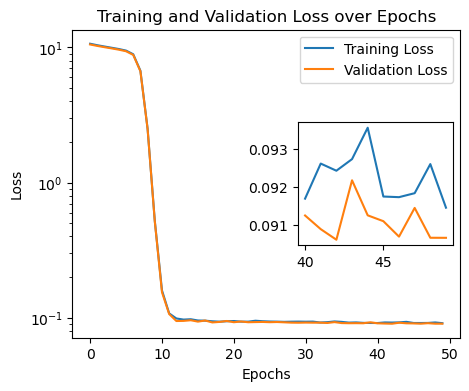

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.yscale('log')
plt.legend(loc='upper right')

last_epochs = 10

# Add a small inset zoomed view of the last 10 epochs
ax = plt.gca()  # Get the current axes
inset_ax = inset_axes(ax, width="40%", height="40%", loc="center right")  # Adjust as needed

# Plot the zoomed-in section on the inset
inset_ax.plot(range(len(train_losses) - last_epochs, len(train_losses)), train_losses[-last_epochs:], label="Training Loss")
inset_ax.plot(range(len(val_losses) - last_epochs, len(val_losses)), val_losses[-last_epochs:], label="Validation Loss")

# Save the figure 
# plt.savefig("vLSTM_train_val_loss.png", dpi=300, bbox_inches='tight')

plt.show()

# Predict on test data

In [6]:
n_samples = 100

# Timing
start = time.time()

# Predict on test data, sampling to obtain uncertainty estimation, plot for each output
predictions, true_values = predict_with_uncertainty(model, test_loader, n_samples=n_samples, scaler_y=scaler_y)

end = time.time()
cpu_time = end - start
print(f"CPU training time: {cpu_time:.4f} seconds")

# Calculate mean and confidence intervals
mean_predictions, ci = calculate_mean_and_ci(predictions)

CPU training time: 22.5841 seconds


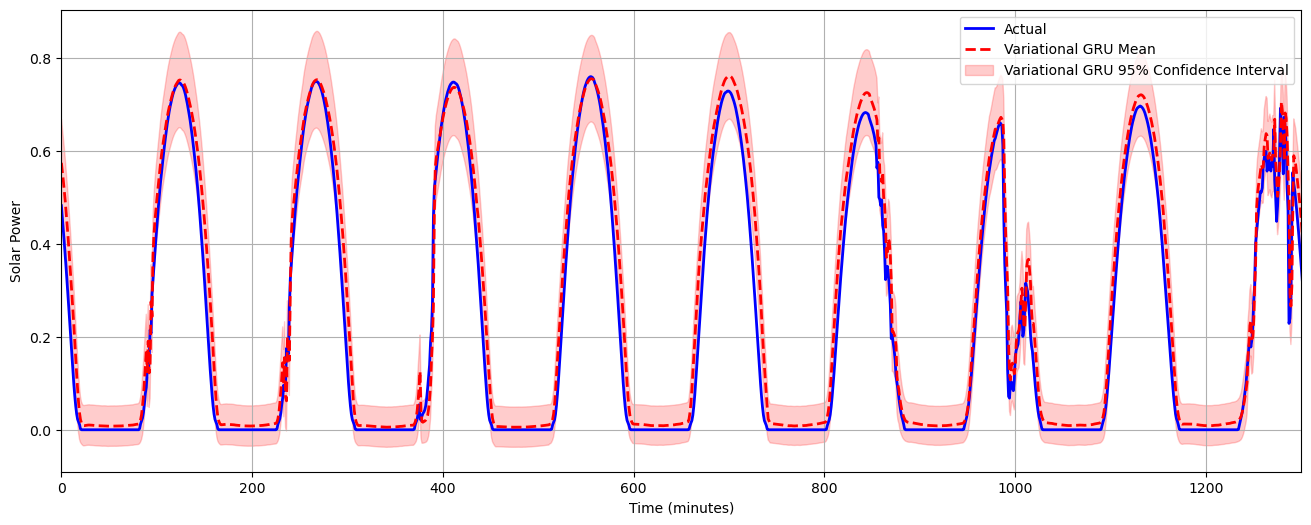

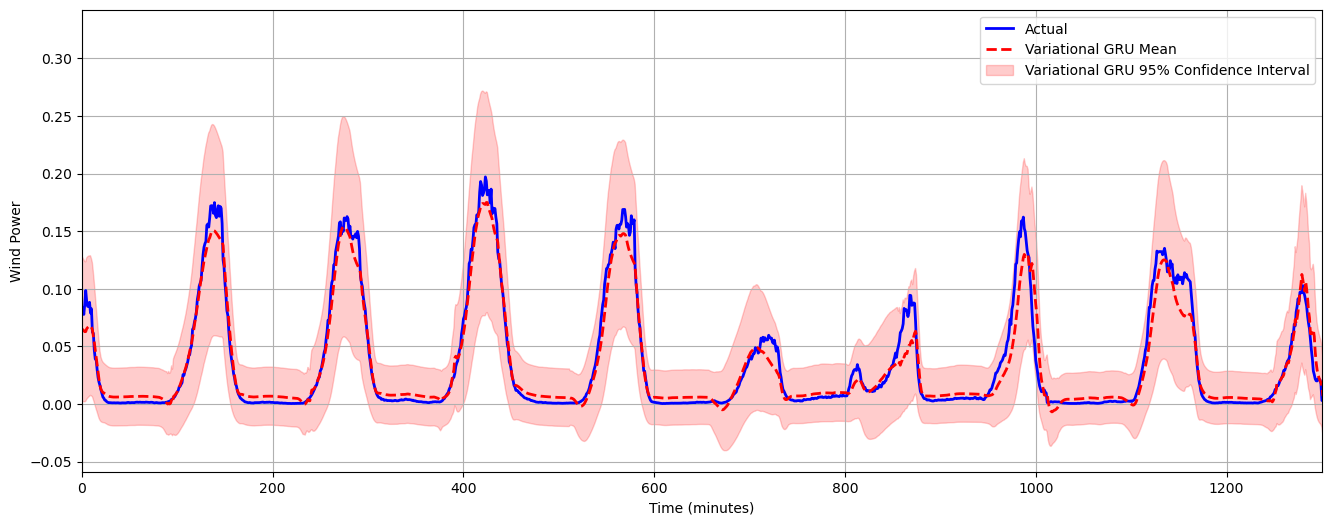

In [8]:
labels = ['Solar Power', 'Wind Power']

# Plot predictions vs actuals
for output_index, label in zip(range(0,2), labels):
    plt.figure(figsize=(16, 6))
        
    # Plot true values (ground truth)
    plt.plot(true_values[:, output_index], label='Actual', color='blue', linewidth=2)
    
    # Plot predicted mean
    plt.plot(mean_predictions[:, output_index], label='Variational GRU Mean', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals (mean +/- confidence interval)
    plt.fill_between(
        np.arange(mean_predictions.shape[0]),
        mean_predictions[:, output_index] - ci[:, output_index],
        mean_predictions[:, output_index] + ci[:, output_index],
        color='red', alpha=0.2, label='Variational GRU 95% Confidence Interval'
    )

    plt.ylabel(label)
    plt.xlabel('Time (minutes)')
    plt.xlim(0, 1300)
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Calculate R2, MAE, RMSE

In [10]:
calculate_and_display_metrics(true_values, mean_predictions)

Output 1:
  R² score: 0.9775
  MAE score: 0.0254
  RMSE score: 0.0400

Output 2:
  R² score: 0.9487
  MAE score: 0.0081
  RMSE score: 0.0128



In [7]:
def save_arrays_to_csv(array1: np.ndarray, array2: np.ndarray, array3: np.ndarray, filename: str):
    # Create a DataFrame from the three arrays
    df = pd.DataFrame({
        'True Solar': array1[:, 0],
        'True Wind': array1[:, 1],
        'Predicted Mean Solar': array2[:, 0],
        'Predicted Mean Wind': array2[:, 1],
        'Predicted Std. Dev. Solar': array3[:, 0],
        'Predicted Std. Dev. Wind': array3[:, 1]
    })

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)


save_arrays_to_csv(true_values, mean_predictions, ci, 'vLSTMTest.csv')

# Predict on training data

In [11]:
n_samples = 50

# Predict on test data, sampling to obtain uncertainty estimation, plot for each output
predictions, true_values = predict_with_uncertainty(model, train_loader, n_samples=n_samples, scaler_y=scaler_y)

# Calculate mean and confidence intervals
mean_predictions, ci = calculate_mean_and_ci(predictions)

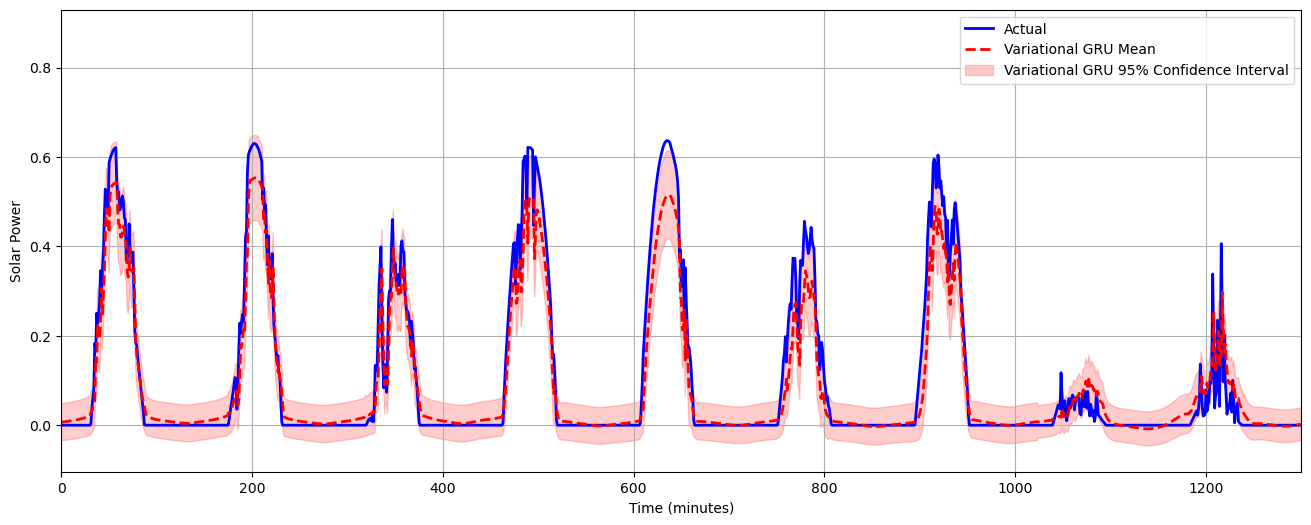

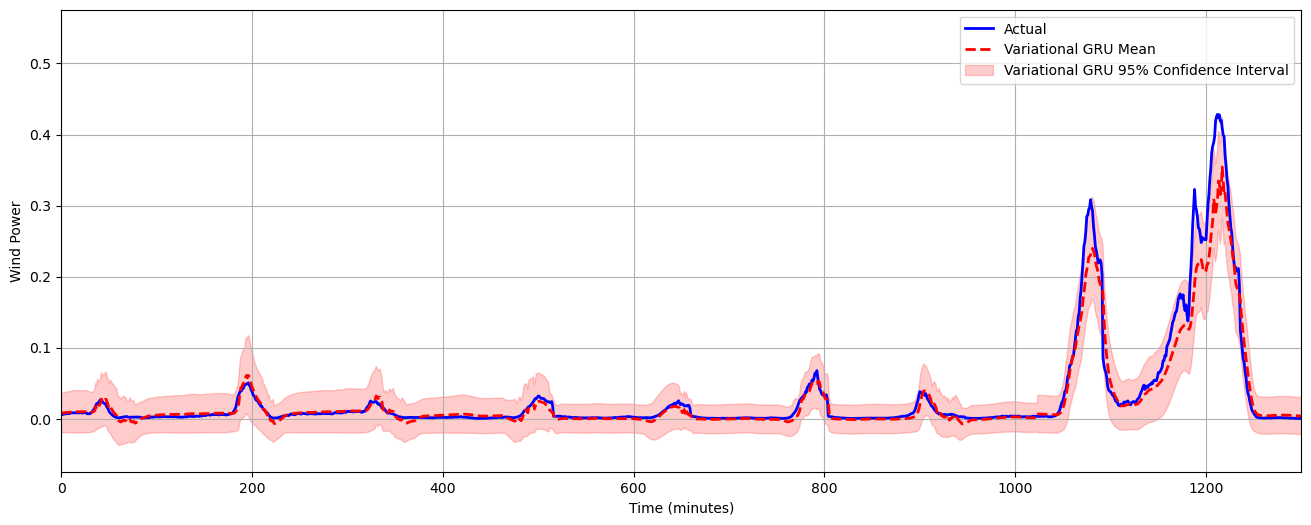

In [12]:
labels = ['Solar Power', 'Wind Power']

# Plot predictions vs actuals
for output_index, label in zip(range(0,2), labels):
    plt.figure(figsize=(16, 6))
        
    # Plot true values (ground truth)
    plt.plot(true_values[:, output_index], label='Actual', color='blue', linewidth=2)
    
    # Plot predicted mean
    plt.plot(mean_predictions[:, output_index], label='Variational GRU Mean', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals (mean +/- confidence interval)
    plt.fill_between(
        np.arange(mean_predictions.shape[0]),
        mean_predictions[:, output_index] - ci[:, output_index],
        mean_predictions[:, output_index] + ci[:, output_index],
        color='red', alpha=0.2, label='Variational GRU 95% Confidence Interval'
    )

    plt.ylabel(label)
    plt.xlabel('Time (minutes)')
    plt.xlim(0, 1300)
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [13]:
calculate_and_display_metrics(true_values, mean_predictions)

Output 1:
  R² score: 0.9626
  MAE score: 0.0318
  RMSE score: 0.0511

Output 2:
  R² score: 0.9570
  MAE score: 0.0089
  RMSE score: 0.0164

